# 0. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.feature_selection import chi2, f_classif
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import balanced_accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from imblearn.over_sampling import SVMSMOTE


import pickle

import warnings
warnings.filterwarnings("ignore")

## 0.0 Functions

In [2]:
def model_evaluation(X_train, y_train, model, nome_modelo, folds = 5):

    ac_treino = np.round(balanced_accuracy_score(y_true = y_train, y_pred = model.predict(X_train)), 2)
    ac_cv = np.round(np.mean(cross_val_score(estimator = model, X = X_train, y = y_train, scoring = "balanced_accuracy", cv = folds)), 2)
    
    f1_treino = np.round(f1_score(y_true = y_train, y_pred = model.predict(X_train)), 2)
    f1_cv = np.round(np.mean(cross_val_score(estimator = model, X = X_train, y = y_train, scoring = "f1", cv = folds)), 2)

    row_evaluation = {"Modelo": nome_modelo, "BalancedAc(treino)": ac_treino, "BalancedAc(Cross Val.)": ac_cv, "f1(treino)": f1_treino, "f1(Cross Val.)": f1_cv}

    return row_evaluation

## 0.1 Load data

In [3]:
df = pd.read_csv("Employee.csv")
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


**Columns Description**

- Education -> EDUCATION LEVEL
- JoiningYear -> YEAR OF JOINING COMPANY
- City -> CITY OFFICE WHERE POSTED
- PaymentTier -> PAYMENT TIER: 1: HIGHEST 2: MID LEVEL 3:LOWEST
- Age -> CURRENT AGE
- Gender -> GENDER OF EMPLOYEE
- EverBenched -> EVER KEPT OUT OF PROJECTS FOR 1 MONTH OR MORE
- ExperienceInCurrentDomain -> EXPERIENCE IN CURRENT FIELD
- LeaveOrNot -> WHETHER EMPLOYEE LEAVES THE COMPANY IN NEXT 2 YEARS

# 1. Data Description

The description of the data will be carried out and also the Descriptive Statistics to describe the data.

## 1.1 Data Size

In [4]:
print("N° linhas:", df.shape[0])
print("N° colunas:", df.shape[1])

N° linhas: 4653
N° colunas: 9


## 1.2 Data Types

In [5]:
df.dtypes

Education                    object
JoiningYear                   int64
City                         object
PaymentTier                   int64
Age                           int64
Gender                       object
EverBenched                  object
ExperienceInCurrentDomain     int64
LeaveOrNot                    int64
dtype: object

## 1.3 Check NaN

In [6]:
df.isnull().sum()

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
LeaveOrNot                   0
dtype: int64

## 1.4 Descriptive Statistical

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
JoiningYear,4653.0,2015.062970,1.863377,2012.0,2013.0,2015.0,2017.0,2018.0
PaymentTier,4653.0,2.698259,0.561435,1.0,3.0,3.0,3.0,3.0
Age,4653.0,29.393295,4.826087,22.0,26.0,28.0,32.0,41.0
ExperienceInCurrentDomain,4653.0,2.905652,1.558240,0.0,2.0,3.0,4.0,7.0
LeaveOrNot,4653.0,0.343864,0.475047,0.0,0.0,0.0,1.0,1.0


## 1.5 Lower Case Columns

To be easiest to manipulate, i will turn all columns names in lowercase.

In [8]:
df.columns = df.columns.str.lower()

In [9]:
df.columns

Index(['education', 'joiningyear', 'city', 'paymenttier', 'age', 'gender',
       'everbenched', 'experienceincurrentdomain', 'leaveornot'],
      dtype='object')

In [10]:
df.columns = ['education', 'joining_year', 'city', 'payment_tier', 'age', 'gender',
       'ever_benched', 'experience_current_domain', 'leave']

# 2. Feature Engineering

## 2.1  Feature Engineering

In [11]:
df["time_employed"] = 2018 - df.joining_year

# 3. Exploratory Data Analysis

In the Exploratory Data Analysis the data will be better analized and hypotheses will be raised in order to generate insights for the human resources team and also identify the correlation between variables and 'LeaveOrNot'.


## 3.1 Univariate Analysis

In [12]:
num_col = ["age", "experience_current_domain", "time_employed"]
cat_col = ["education", "city", "payment_tier", "gender", "ever_benched"]
target_col = "leave"

### 3.1.1 Response Variable

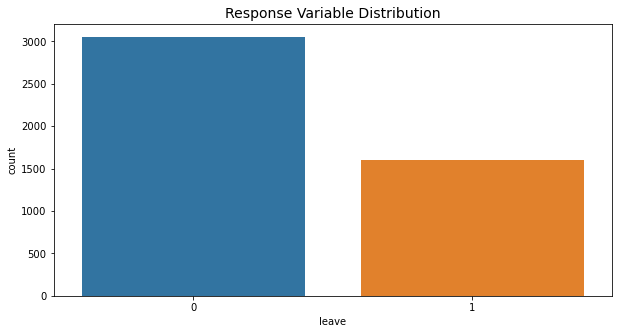

In [70]:
plt.figure(figsize = [10,5])
sns.countplot(df["leave"])
plt.title("Response Variable Distribution", fontsize = 14)
plt.show()

In [71]:
(df.leave.value_counts() / df.shape[0]) * 100

0    65.613583
1    34.386417
Name: leave, dtype: float64

Our dataset is a little bit inmbalanced, we will deal with this later in the notebook.

### 3.1.2 Numerical Variables

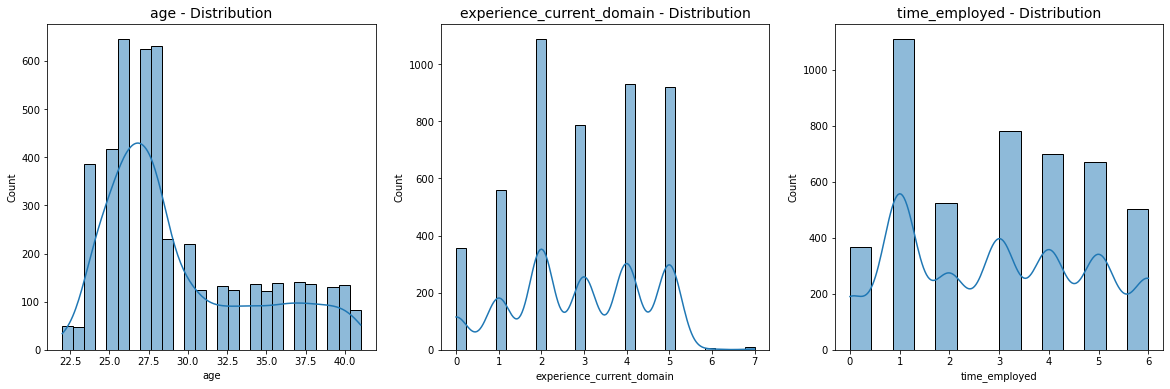

In [72]:
plt.figure(figsize = [20, 6])

for i in num_col:
    plt.subplot(1, 3, num_col.index(i) + 1)
    sns.histplot(df[i], kde = True)
    plt.title(i + " - Distribution", fontsize = 14)
plt.show()

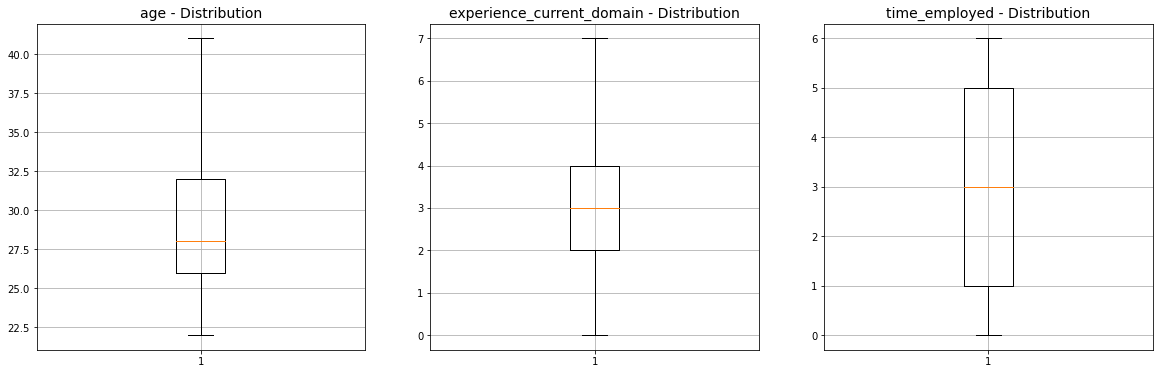

In [73]:
plt.figure(figsize = [20, 6])

for i in num_col:
    plt.subplot(1, 3, num_col.index(i) + 1)
    plt.boxplot(df[i])
    plt.title(i + " - Distribution", fontsize = 14)
    plt.grid()
plt.show()

### 3.1.3 Categorical Variables

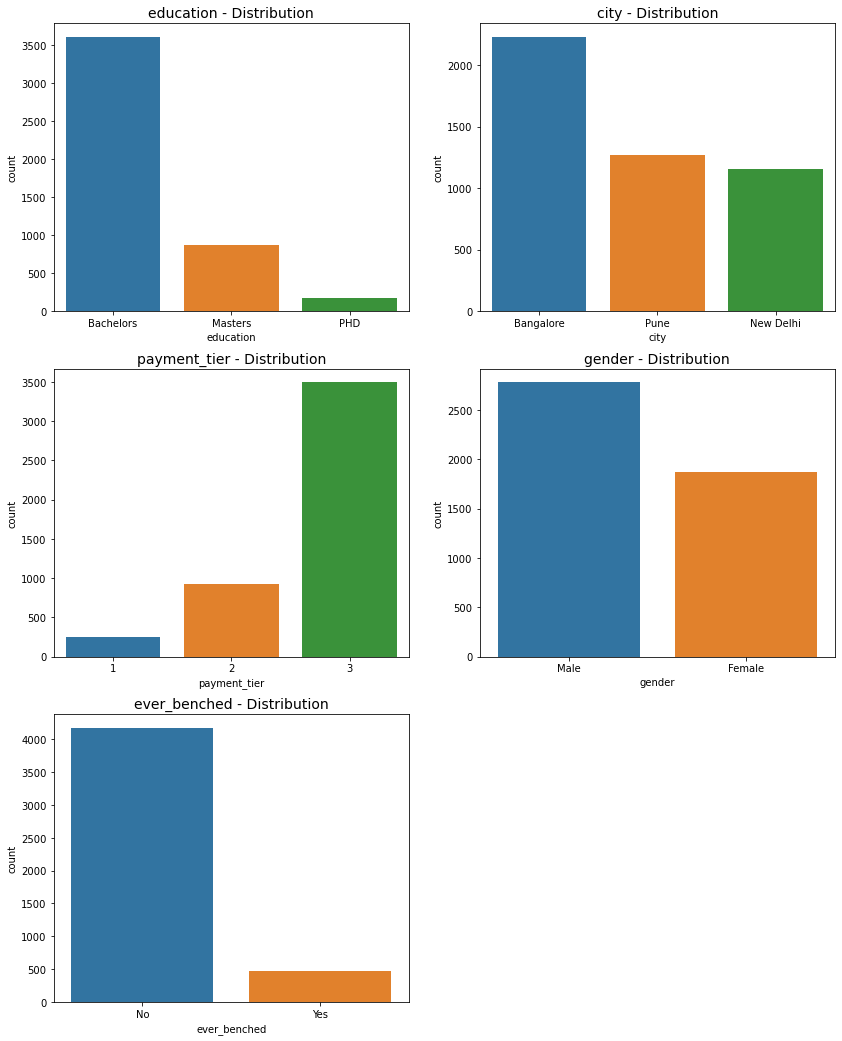

In [74]:
plt.figure(figsize = [14, 18])

for i in cat_col:
    plt.subplot(3, 2, cat_col.index(i) + 1)
    sns.countplot(df[i])
    plt.title(i + " - Distribution", fontsize = 14)
plt.show()

## 3.2 Bivariate Analysis

Here we will analyze the relationship between the attributes and the target variable, in order to discover the characteristics of an employee who leaves the company.

### 3.2.1 Numerical Variables

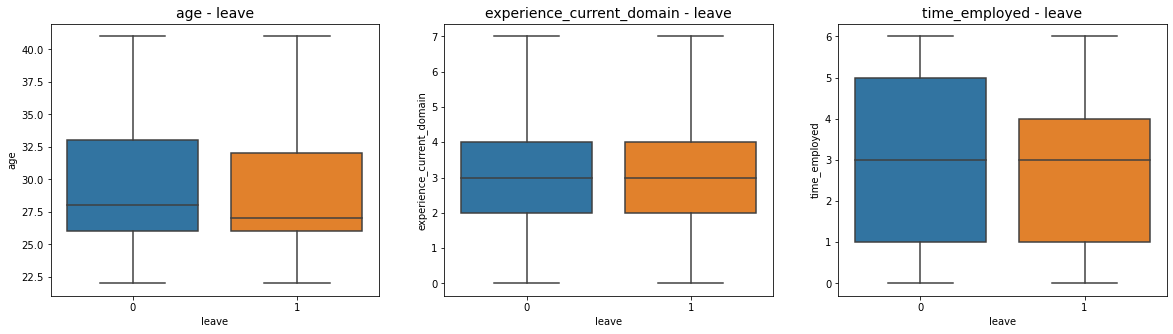

In [75]:
plt.figure(figsize = [20, 5])
for i in num_col:
    plt.subplot(1, 3, num_col.index(i) + 1)
    sns.boxplot(df["leave"], df[i])
    plt.title(i + " - leave", fontsize = 14)    
plt.show()

### 3.2.2 Categorical Variables

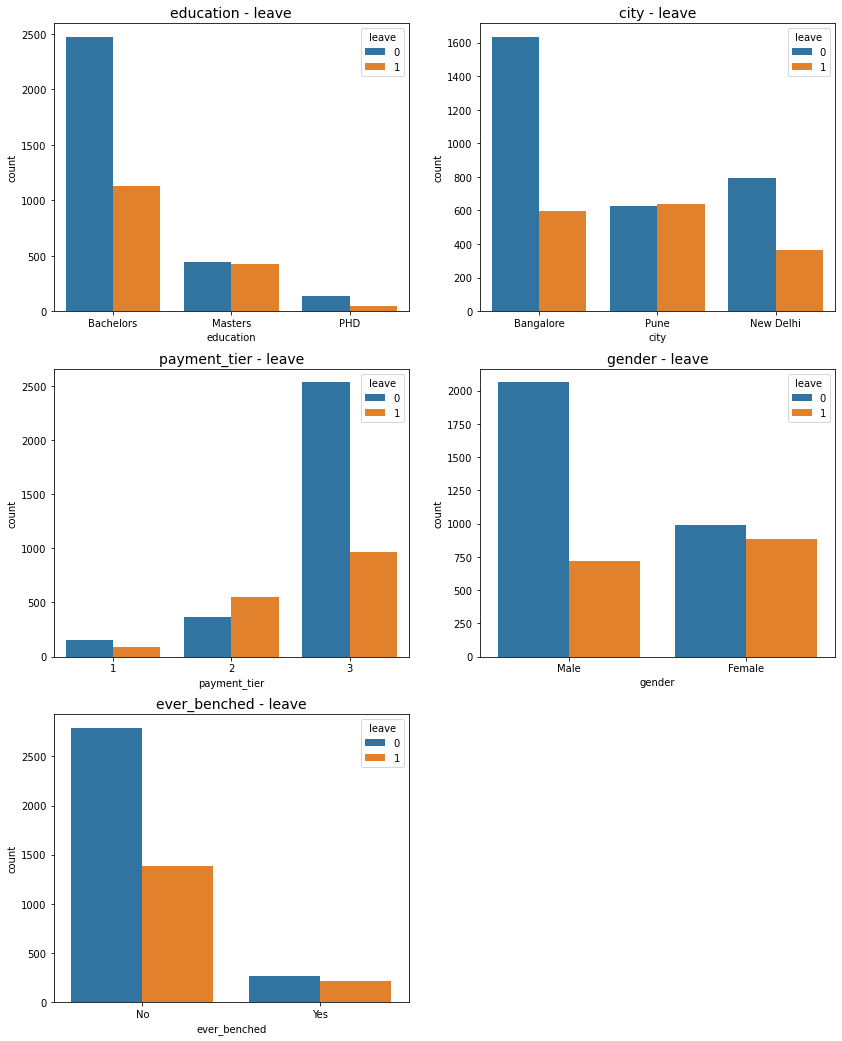

In [76]:
plt.figure(figsize = [14, 18])
for i in cat_col:
    plt.subplot(3, 2, cat_col.index(i) + 1)
    sns.countplot(df[i], hue = df["leave"])
    plt.title(i + " - leave", fontsize = 14)    
plt.show()

## 3.3 Particulars of a employee who leave the company

### P1: Employees with less time into the company

Employees who left the company have an average of years in the company of 2.46 years while who doesn't left have an average of years of 3.18.

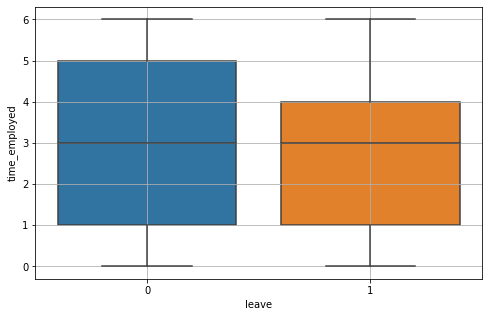

Mean - years employed - Left: 2.469375

Mean - years employed - Not Left: 3.182115951523092


In [24]:
plt.figure(figsize = [8, 5])
sns.boxplot(df["leave"], df["time_employed"])
plt.grid()
plt.show()

print("Mean - years employed - Left:",np.mean(df[df["leave"] == 1]["time_employed"]))
print()
print("Mean - years employed - Not Left:",np.mean(df[df["leave"] == 0]["time_employed"]))

### P2: Employees with Master degree

48,8% of the employees with Master Degree left the company.

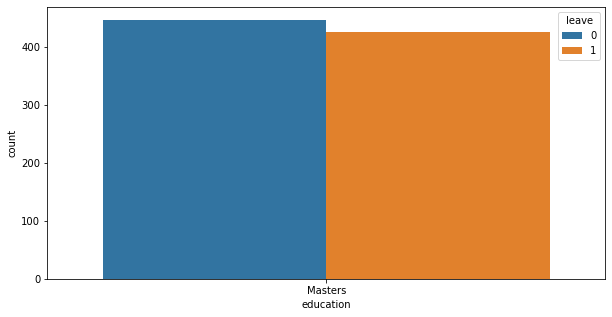

In [25]:
plt.figure(figsize = [10,5])
sns.countplot(df[df["education"] == "Masters"]["education"], hue = df["leave"], dodge = True)
plt.show()

In [26]:
(df[df["education"] == "Masters"]["leave"].value_counts() / df[df["education"] == "Masters"].shape[0]) * 100

0    51.202749
1    48.797251
Name: leave, dtype: float64

### P3: Employees from Pune

50,4% of the employees from Pune left the company.

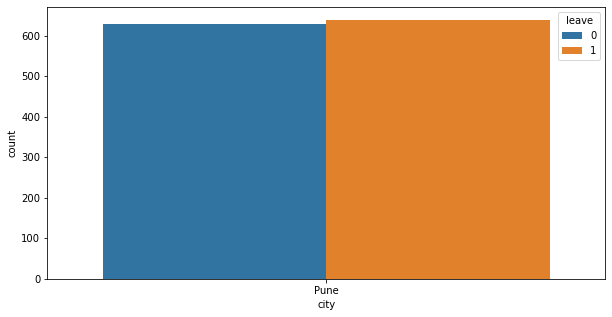

In [27]:
plt.figure(figsize = [10,5])
sns.countplot(df[df["city"] == "Pune"]["city"], hue = df["leave"], dodge = True)
plt.show()

In [28]:
(df[df["city"] == "Pune"]["leave"].value_counts() / df[df["city"] == "Pune"].shape[0]) * 100

1    50.394322
0    49.605678
Name: leave, dtype: float64

### P4: Employees with median level payment

59,9% of the employees with median level payment left the company.

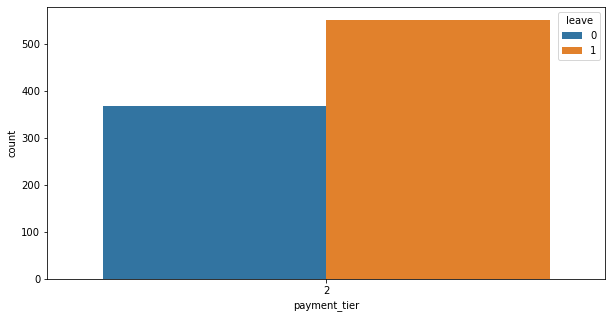

In [29]:
plt.figure(figsize = [10,5])
sns.countplot(df[df["payment_tier"] == 2]["payment_tier"], hue = df["leave"], dodge = True)
plt.show()

In [30]:
(df[df["payment_tier"] == 2]["leave"].value_counts() / df[df["payment_tier"] == 2].shape[0]) * 100

1    59.912854
0    40.087146
Name: leave, dtype: float64

### P5: Female employees

47% of the  female employees left the company.

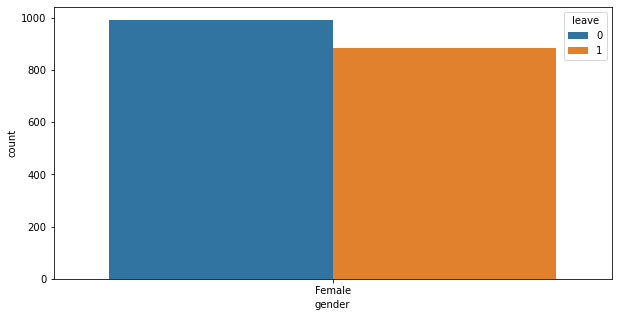

In [31]:
plt.figure(figsize = [10,5])
sns.countplot(df[df["gender"] == "Female"]["gender"], hue = df["leave"], dodge = True)
plt.show()

In [32]:
(df[df["gender"] == "Female"]["leave"].value_counts() / df[df["gender"] == "Female"].shape[0]) * 100

0    52.853333
1    47.146667
Name: leave, dtype: float64

### P6: Employees who ever benched

45,4% of the employees who ever benched left the company.

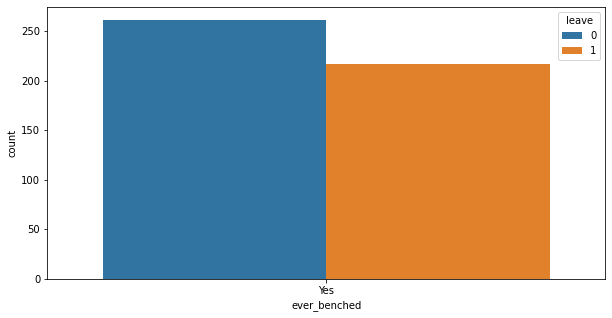

In [33]:
plt.figure(figsize = [10,5])
sns.countplot(df[df["ever_benched"] == "Yes"]["ever_benched"], hue = df["leave"], dodge = True)
plt.show()

In [34]:
(df[df["ever_benched"] == "Yes"]["leave"].value_counts() / df[df["ever_benched"] == "Yes"].shape[0]) * 100

0    54.60251
1    45.39749
Name: leave, dtype: float64

# 4. Machine Learning

## 4.1 Pre-processing

In [31]:
df2 = df.copy()

#### Removing joining_year column

In [32]:
df2 = df.drop("joining_year", axis = 1)

### Feature Selection

We will use some statistical tests to confirm the hypotheses generated by the bivariate analysis, discover new relationships and select the best variables for the model.

#### Chi² for categorical features

In [15]:
df_temp = df2.copy()

for i in cat_col:
    le = LabelEncoder()
    df_temp[i] = le.fit_transform(df_temp[i].values.reshape(-1, 1))

df_chi2 = pd.DataFrame(columns = ["feature", "chi2", "p-value"])
for i in cat_col:
    row = {"feature":i, "chi2": np.round(chi2(df_temp[i].values.reshape(-1, 1), df_temp["leave"].values.reshape(-1, 1))[0], 2), \
           "p-value":np.round(chi2(df_temp[i].values.reshape(-1, 1), df_temp["leave"].values.reshape(-1, 1))[1], 4)}
    
    df_chi2 = df_chi2.append(row, ignore_index = True)
    
df_chi2

,feature,chi2,p-value
0,education,[30.94],[0.0]
1,city,[167.97],[0.0]
2,payment_tier,[33.73],[0.0]
3,gender,[91.33],[0.0]
4,ever_benched,[25.69],[0.0]


#### ANOVA for numerical features

In [16]:
df_anova = pd.DataFrame(columns = ["feature", "f-value", "p-value"])
for i in num_col:
    row = {"feature":i, "f-value": np.round(f_classif(df_temp[i].values.reshape(-1, 1), df_temp["leave"].values.reshape(-1, 1))[0], 2), \
           "p-value":np.round(f_classif(df_temp[i].values.reshape(-1, 1), df_temp["leave"].values.reshape(-1, 1))[1], 4)}
    
    df_anova = df_anova.append(row, ignore_index = True)
    
df_anova

,feature,f-value,p-value
0,age,[12.19],[0.0005]
1,experience_current_domain,[4.33],[0.0375]
2,time_employed,[158.8],[0.0]


Whe can se that the only column with no significance for our problem is the experience_current_domain.

In [33]:
df2 = df2.drop(["experience_current_domain"], axis = 1)

### One Hot Encoding

Transforming categorical columns to binary columns.

In [34]:
df2.gender = df2.gender.replace({"Male":0, "Female":1})
df2.ever_benched = df2.ever_benched.replace({"No":0, "Yes":1})

ohe = OneHotEncoder()
df_temp = pd.DataFrame(ohe.fit_transform(df2["city"].values.reshape(-1,1)).toarray(), columns = ["city_" + str(x) for x in ohe.categories_[0]])
df2 = pd.concat([df2, df_temp], axis = 1)
df2 = df2.drop("city", axis = 1)

### Label Encoder

Some categorical columns like education and payment_tier are ordinal, that means that the order of the values have importance. In this cases whe will use Label Encoder.

In [35]:
le = LabelEncoder()
df2["education"] = le.fit_transform(df2["education"].values.reshape(-1, 1))

### Normalizing

Whe have to put all the values in the same scale, because some ml models work with distance and if the values among columns have scales to much diferent, the model may give more importance to this columns.

In [36]:
var_minmax = ["education", "payment_tier", "age", "time_employed"]

In [37]:
for i in var_minmax:
    mm_scaler = MinMaxScaler()
    df2[i] = mm_scaler.fit_transform(df2[i].values.reshape(-1, 1))
    
    #Exporting one at one for using in production
    pickle.dump(mm_scaler, open(str(i) + "_encoder.pkl", "wb"))

In [40]:
df2.head()

,education,payment_tier,age,gender,ever_benched,leave,time_employed,city_Bangalore,city_New Delhi,city_Pune
0,0.0,1.0,0.631579,0,0,0,0.166667,1.0,0.0,0.0
1,0.0,0.0,0.315789,1,0,1,0.833333,0.0,0.0,1.0
2,0.0,1.0,0.842105,1,0,0,0.666667,0.0,1.0,0.0
3,0.5,1.0,0.263158,0,0,1,0.333333,1.0,0.0,0.0
4,0.5,1.0,0.105263,0,1,1,0.166667,0.0,0.0,1.0


In [41]:
df.head()

,education,joining_year,city,payment_tier,age,gender,ever_benched,experience_current_domain,leave,time_employed
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0,1
1,Bachelors,2013,Pune,1,28,Female,No,3,1,5
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0,4
3,Masters,2016,Bangalore,3,27,Male,No,5,1,2
4,Masters,2017,Pune,3,24,Male,Yes,2,1,1


In [45]:
np.sort(df.age.unique())

array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41], dtype=int64)

### Dividing train / test

Spliting the dataset in train and test.

In [22]:
X = df2.drop("leave", axis = 1)
y = df2["leave"]

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.20, random_state = 11, stratify=y)

## 4.2 Modeling

### LogisticRegression

In [90]:
logreg = LogisticRegression(class_weight="balanced")
logreg.fit(Xtrain, ytrain)

LogisticRegression(class_weight='balanced')

In [91]:
model1_row = model_evaluation(Xtrain, ytrain, logreg, "Log.Regression")

model1_row

{'Modelo': 'Log.Regression',
 'BalancedAc(treino)': 0.67,
 'BalancedAc(Cross Val.)': 0.66,
 'f1(treino)': 0.57,
 'f1(Cross Val.)': 0.57}

### KNeighbors

In [92]:
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(Xtrain, ytrain)

KNeighborsClassifier(n_neighbors=7)

In [94]:
model2_row = model_evaluation(Xtrain, ytrain, knn, "Knn")
model2_row

{'Modelo': 'Knn',
 'BalancedAc(treino)': 0.81,
 'BalancedAc(Cross Val.)': 0.77,
 'f1(treino)': 0.76,
 'f1(Cross Val.)': 0.7}

### RandomForest

In [95]:
forest = RandomForestClassifier(class_weight = "balanced", min_samples_leaf = 8 )
forest.fit(Xtrain, ytrain)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=8)

In [96]:
model3_row = model_evaluation(Xtrain, ytrain, forest, "RandomForest")
model3_row

{'Modelo': 'RandomForest',
 'BalancedAc(treino)': 0.82,
 'BalancedAc(Cross Val.)': 0.81,
 'f1(treino)': 0.78,
 'f1(Cross Val.)': 0.75}

### Gradient Boosting

In [99]:
gb = GradientBoostingClassifier(subsample=0.8, min_samples_leaf = 8, learning_rate = 0.2)
gb.fit(Xtrain, ytrain)

GradientBoostingClassifier(learning_rate=0.2, min_samples_leaf=8, subsample=0.8)

In [100]:
model4_row = model_evaluation(Xtrain, ytrain, gb, "GradientBoosting")
model4_row

{'Modelo': 'GradientBoosting',
 'BalancedAc(treino)': 0.82,
 'BalancedAc(Cross Val.)': 0.8,
 'f1(treino)': 0.77,
 'f1(Cross Val.)': 0.74}

## 4.3 Hiperparameter Tuning

The model with the best perfomance and the smaller overfitting is the Random Forest Classifier. With the best model in hands, lets tune the hiperparameters. I will use Randomized Search.

In [104]:
params = {"max_depth":[3, 5, 8, 13, 21],
          "min_samples_leaf": [5, 8, 13, 21, 34],
          "max_features":["log2", "sqrt", None]}

clf = RandomizedSearchCV(RandomForestClassifier(class_weight="balanced", n_estimators=150), param_distributions=params, n_iter=50, cv=5, scoring="f1")
clf.fit(Xtrain, ytrain)
print(clf.best_params_)
print()
print(clf.best_score_)

{'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 8}

0.7580139636971124


In [24]:
final_model = RandomForestClassifier(class_weight="balanced", n_estimators=150, min_samples_leaf=5, max_depth=8, max_features="log2")
final_model.fit(Xtrain, ytrain)

RandomForestClassifier(class_weight='balanced', max_depth=8,
                       max_features='log2', min_samples_leaf=5,
                       n_estimators=150)

In [25]:
final_row = model_evaluation(Xtrain, ytrain, final_model, "GradientBoosting")
final_row

{'Modelo': 'GradientBoosting',
 'BalancedAc(treino)': 0.82,
 'BalancedAc(Cross Val.)': 0.81,
 'f1(treino)': 0.78,
 'f1(Cross Val.)': 0.76}

## 4.3 Model evaluation on test

We have choose the best model, and the best parameters. Now We will evaluate the model generalization with the test dataset.

In [26]:
metrics = [balanced_accuracy_score, f1_score, recall_score, precision_score]
metric_grid = {}

for i in metrics:
        metric_grid[str(metrics[metrics.index(i)]).split(' ')[1]] = i(y_true = ytest, y_pred = final_model.predict(Xtest))
        
metric_grid

{'balanced_accuracy_score': 0.8298434942716857,
 'f1_score': 0.7793880837359098,
 'recall_score': 0.75625,
 'precision_score': 0.8039867109634552}

## 4.4 Exporting model and transformers

We need to export the model and the transformers in a pickle file, to later we deploy the model into production.

In [30]:
pickle.dump(final_model, open("employee_model.pkl", "wb"))

In [38]:
pickle.dump(le, open("label_encoder_education.pkl", "wb"))

In [46]:
pickle.dump(ohe, open("ohe_city.pkl", "wb"))

# 5. Conclusion

## 5.1 Relevant features of who left the company

First, human resources can use the insights below about employees to take better decisions.

- **Female employees.**
- **Employees who ever benched.**
- **Emplooyes with less time into the company.**
- **Employees with Master Degree.**
- **Employees from Pune.**
- **Employees with medium payment values.**

## 5.2 Business Evaluation

The average cost of terminating and hiring a new employee to replace is \$15000.00

With this model we were able to identify employees who are about to leave and try to recover them before then.

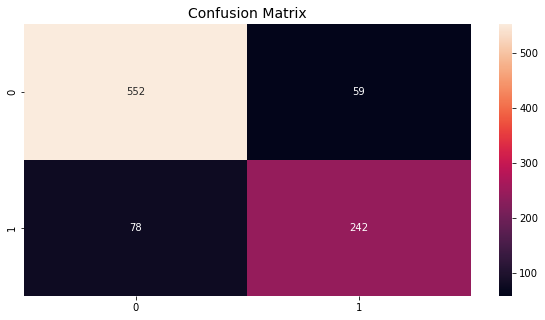

In [29]:
plt.figure(figsize = [10,5])
sns.heatmap(confusion_matrix(y_true = ytest, y_pred = final_model.predict(Xtest)), annot = True, fmt="g")
plt.title("Confusion Matrix", fontsize = 14)
plt.show()

As we can see, our model can identify correctly 75% of the employees that will turnover in the future. If we consider that we can retain only 50% of the employees that our model identify, our model can reduce the expected loss of employee from \$15000 to 9475.00, a reduce of 36%.